In [9]:
using ConstrainedLasso, PyPlot

In [1]:
# a function pava for pooled adjacent violation algorithm

function pava(v; w = ones(length(v)))
    n = length(v);
    if n != length(w)
        throw(DimensionMismatch("Lengths of values and weights mismatch"))
    end
    
    out = ones(n);
    j = 1;
    S = Dict(0 => 0, 1 => 1);
    vdash = Dict(1 => v[1]);
    wdash = Dict(1 => w[1]);
    @inbounds begin
        for i = 2:n
            j = j+1;
            vdash[j] = v[i];
            wdash[j] = w[i];
            while j > 1 && vdash[j] < vdash[j-1];
                vdash[j-1] = (wdash[j] * vdash[j] + wdash[j-1] * vdash[j-1]) /
                   (wdash[j] + wdash[j-1]);
                wdash[j-1] = wdash[j] + wdash[j-1];
                j = j-1;
            end
            S[j] = i;
        end
        for k = 1:j
            for l in S[k-1]+1 : S[k]
                out[l] = vdash[k];
            end
        end
    end
    return out
end

# a function quadratic to solve a univariate quadratic equation

function quadratic(a, b, c)
    discr = b^2 - 4*a*c
    return (-b + sqrt(discr))/(2a)
end

quadratic (generic function with 1 method)

In [2]:
# a function for BSGM_general (Section 2,3)

# x          : a noisy observation of an isotonic sequence
# init_theta : initialization of theta, with default a pava solution
# v0, v1     : tuning parameters

function bayes_iso(x; init_x = pava(x), v0 = 1e-1, v1 = 1e4, iter = 1000)
    n = length(x);
    
    # initialize
    theta = init_x;
    q = 0.5 * ones(n);
    sigma = sqrt(sum((x - out).^2)/n);
    alpha = mean(y);
    
    # loop start
    for i = 1:1000
        temp = out[2:end] - out[1:end-1];
        q = 1./( 1 + v0/v1 * exp.(temp/sigma*(1/v0-1/v1)) );
        tau = q/v0 + q/v1;
        a = n + sum(q); b = -sum(temp .* q); c = -sum((x-out).^2);
        sigma = quadratic(a,b,c)
        theta = pava(y - [0;tau] * sigma + [tau;0] * sigma);
    end
    return Dict([
                (:alpha,alpha), (:theta,theta), (:sigma, sigma), (:q,q)
                ])
end

bayes_iso (generic function with 1 method)

In [3]:
warming = readcsv(joinpath(Pkg.dir("ConstrainedLasso"),"docs/src/demo/misc/warming.csv"), header=true)[1];
year = warming[:, 1];
y    = warming[:, 2];
hcat(year, y);

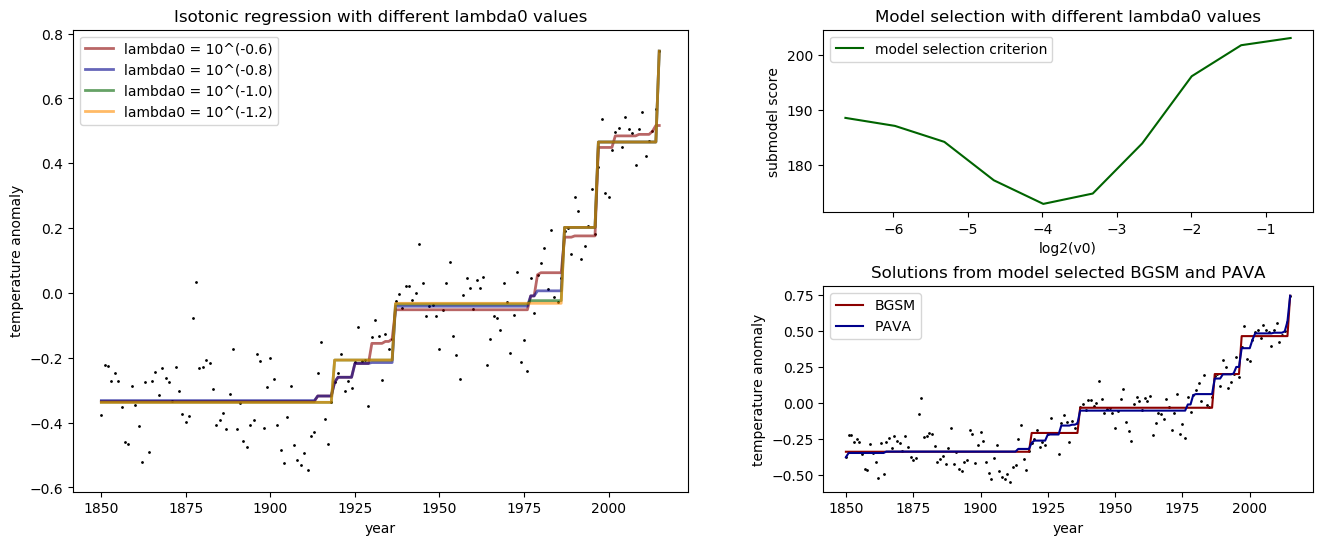

In [15]:
fig, axs = subplots(2, 3, figsize = (16, 6))
ax = subplot2grid((20,20), (0,0), rowspan = 20, colspan = 10)
ax[:plot](year, out1[:theta], "r-", linewidth=2, color = "darkred", label="lambda0 = 10^(-0.6)", alpha=0.6)
ax[:plot](year, out2[:theta], "r-", linewidth=2, color = "darkblue", label="lambda0 = 10^(-0.8)", alpha=0.6)
ax[:plot](year, out3[:theta], "r-", linewidth=2, color = "darkgreen", label="lambda0 = 10^(-1.0)", alpha=0.6)
ax[:plot](year, out4[1], "r-", linewidth=2, color = "darkorange", label="lambda0 = 10^(-1.2)", alpha=0.6)
ax[:scatter](year, y, s = 1, color = "black")
ax[:legend](loc="upper left")
xlabel("year"); ylabel("temperature anomaly")
title("Isotonic regression with different lambda0 values")
ax2 = subplot2grid((20,20), (0,12), rowspan = 8, colspan = 8)
ax2[:plot](log2.(v0_range),out, color = "darkgreen", label = "model selection criterion");
ax2[:legend](loc="upper left")
xlabel("log2(v0)")
ylabel("submodel score")
title("Model selection with different lambda0 values")
ax3 = subplot2grid((20,20), (11,12), rowspan = 10, colspan = 8)
ax3[:plot](year,res[1], color = "darkred", label="BGSM")
ax3[:plot](year,pava(y), color = "darkblue", label="PAVA")
ax3[:scatter](year,y, s = 1, color = "black")
ax3[:legend](loc="upper left")
xlabel("year");
ylabel("temperature anomaly")
title("Solutions from model selected BGSM and PAVA")
savefig("F1.pdf")

In [9]:
# using RCall
# R"require(neariso)";
# @rput y;
# R"out_neariso <- neariso(y, lambda = 0.5)$beta";
# out_neariso = (@rget out_neariso)[:];
# plot(year, out_neariso, linewidth = 1)